**@author: James V. Talwar** 

# Discovery Set Analysis: AI Alleles, Tumor Mutations, and Age of Diagnosis

**About:** This notebook provides the code needed to generate Figure 3 panels A, B, F, G, H, and I from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses evaluated BRAF V600E mutation carriers and MHC-I autoimmune allele status in skin cutaneous melanoma (SKCM) cases in the TCGA.

## 1. Import Packages; Load Data

In [1]:
import pandas as pd
from collections import defaultdict
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import joblib
import math
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
autoimmuneAlleles = {'HLA-B13:02','HLA-B27:05','HLA-B51:01','HLA-B57:01','HLA-C06:02','HLA-C12:03', "HLA-B39:06"} 
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]
print("Number of discovery cohort individuals under investigation: {}".format(tcgaSummary.shape[0]))

Number of discovery cohort individuals under investigation: 451


In [3]:
#load in preprocessed dictionary mapping SKCM TCGA individuals to mutations
skcmMutations = joblib.load("../GenotypeData/PatientToMutations.pkl") 

In [4]:
#Load in 215 driver mutations and associated MHC-I Best Rank Scores
affinityProfiles = pd.read_csv("../Data/Candidate_Drivers_BR_MHC1.tsv", sep = "\t", index_col = 0)
affinityProfiles.head()

,HLA-A02:167,HLA-A02:168,HLA-A02:169,HLA-A02:170,HLA-A02:171,HLA-B07:16,HLA-B07:17,HLA-B07:18,HLA-B07:19,HLA-B07:20,...,HLA-B07:78,HLA-B07:79,HLA-B07:80,HLA-B07:81,HLA-B07:82,HLA-B15:122,HLA-B15:123,HLA-B15:124,HLA-B15:125,HLA-B15:126
mutations,,,,,,,,,,,,,,,,,,,,,
M_TP53_C275Y,4.1534,4.6106,0.9139,1.8128,4.8308,13.9538,5.1807,9.9415,11.1954,14.5877,...,2.2612,11.9244,6.7736,21.6378,11.9244,1.6482,0.7227,1.1965,1.6482,1.7793
M_VEGFA_D198G,2.1415,1.9666,5.4024,3.3287,1.9311,4.1042,6.4720,3.9223,4.2464,8.8285,...,1.4582,3.3386,5.1494,11.1619,3.3386,9.0944,8.9867,12.4106,9.0944,8.9080
M_SEC22A_D23G,7.9141,9.8365,2.1085,4.5721,6.8805,1.0326,0.1415,0.9966,1.2675,1.2058,...,1.4956,1.5285,1.2330,0.8089,1.5285,0.7152,2.3788,3.8808,0.7152,0.8301
M_TMEFF1_Y107H,8.2554,7.3728,7.5933,3.9047,7.9749,14.7628,20.8333,16.9104,10.0483,11.7193,...,8.0138,13.8768,15.0040,16.4843,13.8768,2.7842,3.7512,4.8404,2.7842,2.5037
M_PPM1E_D246Y,7.9202,6.0824,9.2421,12.8691,4.6913,7.6801,2.4715,16.7910,9.6436,13.2814,...,8.1683,15.4333,10.4856,12.2825,15.4333,1.6243,1.7487,2.2919,1.6243,1.0131


## 2. Data Processing and Formatting

In [5]:
#extract the relevant patient (451) and mutation (drivers) information
patientToMutation = defaultdict(list) #patient to driver mutation mapping
for k,v in skcmMutations.items():
    if k not in tcgaSummary.index:
        continue
    patientToMutation[k] = [mutation for mutation in v if mutation in affinityProfiles.index]

In [6]:
mutationToIndividual = defaultdict(list) #driver mutation to patient mapping
for k,v in patientToMutation.items():
    for mutation in v:
        mutationToIndividual[mutation].append(k)

## 3. Run Analyses and Generate Figures

### 3a. Figures 3A and B: Recurrent Mutations and Age Breakdowns


In [7]:
#sort individuals by age
tcgaSummary = tcgaSummary.sort_values(by = ["Age"], ascending = True)

#since sorted now by age can partition/grab by index
youngestIndividuals = tcgaSummary.iloc[:math.ceil(tcgaSummary.shape[0] * 0.3), :]
oldestIndividuals = tcgaSummary.iloc[math.floor(tcgaSummary.shape[0] * 0.7):, :]
inTheMiddle = tcgaSummary[(~tcgaSummary.index.isin(youngestIndividuals.index)) & (~tcgaSummary.index.isin(oldestIndividuals.index))]
inTheMiddle = pd.concat([youngestIndividuals[youngestIndividuals["Age"] >= 50], inTheMiddle])
youngestIndividuals = youngestIndividuals[youngestIndividuals["Age"] < 50]

print("The number of young individuals < {} is {}.".format(min(inTheMiddle.Age), youngestIndividuals.shape[0]))
print("The number of old individuals >= {} is {}.".format(min(oldestIndividuals.Age), oldestIndividuals.shape[0]))
print("The number of intermediate individuals with ages ranging between {} and {} is {}.".format(min(inTheMiddle.Age), max(inTheMiddle.Age), inTheMiddle.shape[0]))

The number of young individuals < 50 is 129.
The number of old individuals >= 69 is 136.
The number of intermediate individuals with ages ranging between 50 and 69 is 186.


**Figure 3A:**

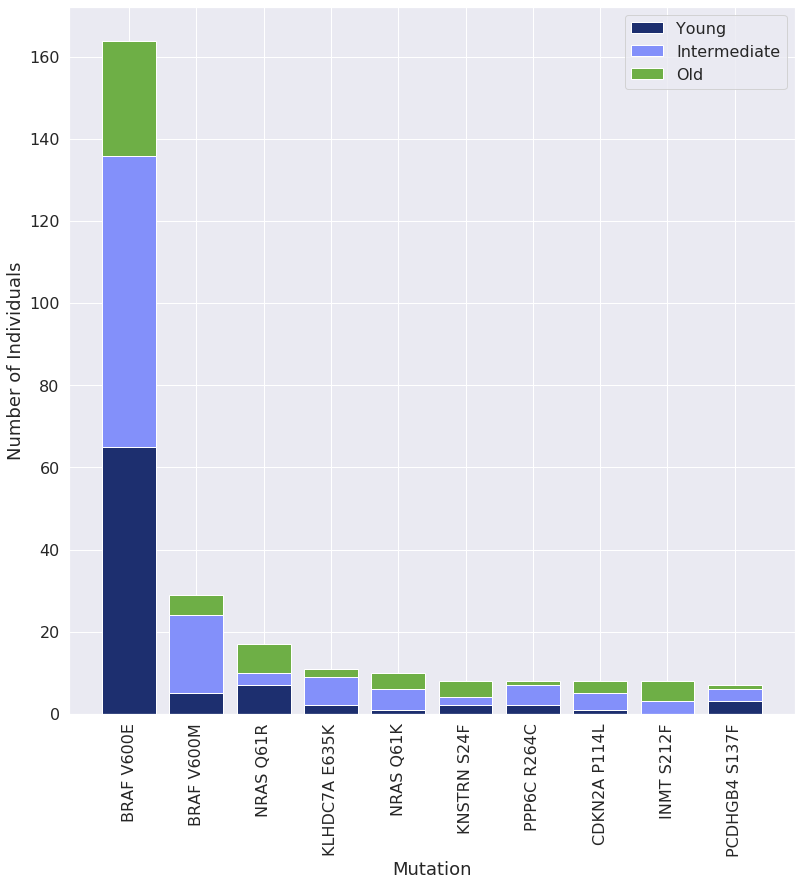

In [8]:
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(13, 13))

numberOfMutationsToPlot = 10
howMany = 0

#iterate through in order of most recurrent mutations
for mutation, individuals in sorted(mutationToIndividual.items(), key = lambda x: len(x[1]), reverse=True):
    howMany += 1
    kerSplat = mutation.split("_") #mutations start wit M_ --> format by gene " " mutation for plotting
    xLabel = kerSplat[1] + " " + kerSplat[-1]

    youth = youngestIndividuals[youngestIndividuals.index.isin(individuals)].shape[0]
    malcolm = inTheMiddle[inTheMiddle.index.isin(individuals)].shape[0]
    dumbledore = oldestIndividuals[oldestIndividuals.index.isin(individuals)].shape[0]
    
    if howMany == 1:
        ax.bar(xLabel, youth, label = "Young", color = '#1D2F6F') #darkblue
        ax.bar(xLabel, malcolm, bottom = youth, label = "Intermediate", color = '#8390FA') #light blue
        ax.bar(xLabel, dumbledore, bottom = youth + malcolm, label = "Old", color = '#6EAF46') #light green
    else:
        ax.bar(xLabel, youth, label = "__nolegend__", color = '#1D2F6F')
        ax.bar(xLabel, malcolm, bottom = youth, label = "__nolegend__", color = '#8390FA')
        ax.bar(xLabel, dumbledore, bottom = youth + malcolm, label = "__nolegend__", color = '#6EAF46')
    
    if howMany == numberOfMutationsToPlot:
        break
        
plt.xlabel("Mutation", fontsize = 18)
plt.ylabel("Number of Individuals", fontsize = 18)
plt.xticks(fontsize = 16, rotation = 90)
plt.yticks(fontsize = 16)
plt.legend(loc="upper right", frameon=True, fontsize=16)

**Figure 3B:**

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

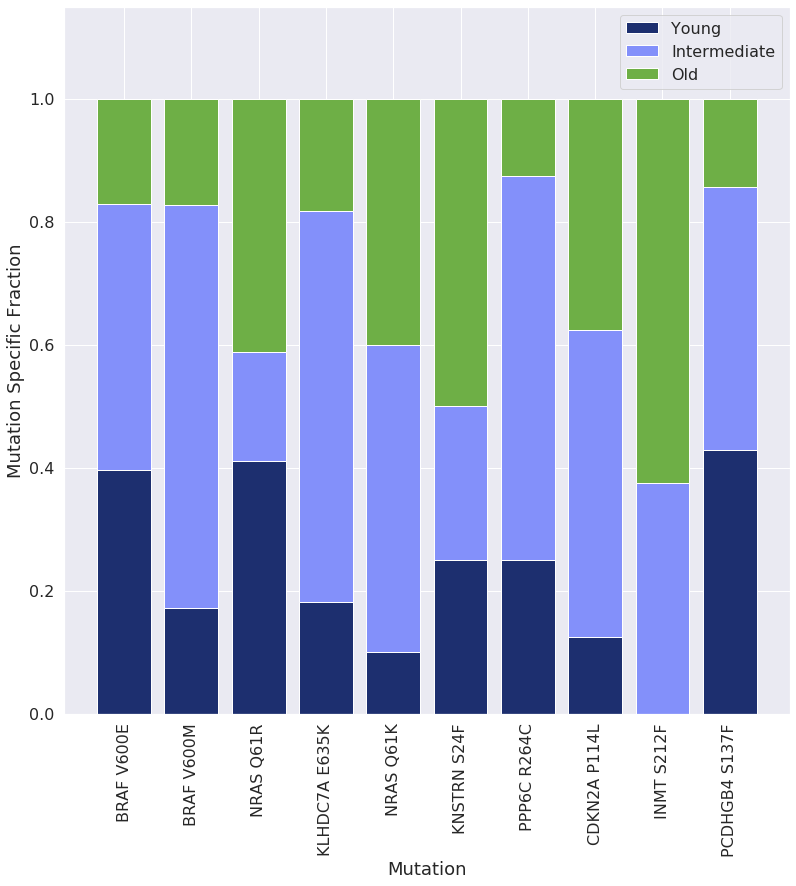

In [9]:
fig, ax = plt.subplots(figsize=(13, 13))
howMany = 0
for mutation, individuals in sorted(mutationToIndividual.items(), key = lambda x: len(x[1]), reverse=True):
    howMany += 1
    kerSplat = mutation.split("_")
    xLabel = kerSplat[1] + " " + kerSplat[-1]
    
    youth = youngestIndividuals[youngestIndividuals.index.isin(individuals)].shape[0]
    malcolm = inTheMiddle[inTheMiddle.index.isin(individuals)].shape[0]
    dumbledore = oldestIndividuals[oldestIndividuals.index.isin(individuals)].shape[0]
    total = youth + malcolm + dumbledore
    if howMany == 1:
        ax.bar(xLabel, youth/total, label = "Young", color = '#1D2F6F')
        ax.bar(xLabel, malcolm/total, bottom = youth/total, label = "Intermediate", color = '#8390FA')
        ax.bar(xLabel, dumbledore/total, bottom = youth/total + malcolm/total, label = "Old", color = '#6EAF46')
    else:
        ax.bar(xLabel, youth/total, label = "__nolegend__", color = '#1D2F6F')
        ax.bar(xLabel, malcolm/total, bottom = youth/total, label = "__nolegend__", color = '#8390FA')
        ax.bar(xLabel, dumbledore/total, bottom = youth/total + malcolm/total, label = "__nolegend__", color = '#6EAF46')
    
    if howMany == numberOfMutationsToPlot:
        break
        
plt.ylim(0, 1.15)
plt.legend(loc="upper right", frameon=True, fontsize=16)
plt.xlabel("Mutation", fontsize = 18)
plt.ylabel("Mutation Specific Fraction", fontsize = 18)
plt.xticks(fontsize = 16, rotation = 90)
plt.yticks(fontsize = 16)


### 3b. TCGA SKCM Mutations: Evaluating significant age differences

Do any mutations show significant age differences?

In [10]:
mutationToPValue = defaultdict(float)
for mutation, individuals in mutationToIndividual.items():
    thoseWithMutation = tcgaSummary[tcgaSummary.index.isin(mutationToIndividual[mutation])]
    thoseWithoutMutation = tcgaSummary[~tcgaSummary.index.isin(mutationToIndividual[mutation])]
    stat,pMutation = mannwhitneyu(thoseWithMutation.Age, thoseWithoutMutation.Age)
    mutationToPValue[mutation] = pMutation #uncorrected p-value

In [11]:
#correct p-values --> Benjamini and Hochberg FDR correction
correction = multipletests(pvals = [el[1] for el in sorted(mutationToPValue.items(), key = lambda x: x[1])], alpha = 0.05, method = "fdr_bh")

#map mutations to corrected p-values
correctedMutationPValues = defaultdict(float)
index = 0
for el in sorted(mutationToPValue.items(), key = lambda x: x[1]):
    correctedMutationPValues[el[0]] = correction[1][index]
    index += 1

In [12]:
#Do any mutations exhibit significant age differences after correction?
significantMutations = [(mut, p) for mut,p in correctedMutationPValues.items() if p <= 0.05]
print("{} mutation(s) exhibit significant age differences. These mutation(s) are:".format(len(significantMutations)))
for el in significantMutations:
    print(el[0] + "; p = {}".format(el[1]))

1 mutation(s) exhibit significant age differences. These mutation(s) are:
M_BRAF_V600E; p = 7.575447490901285e-06


### 3c. Figure 3F - BRAFV600E Status and Age of Diagnosis

Given BRAF V600E is the only significant mutation, visualize and investigate its effects in the cohort.

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Text yticklabel objects>)

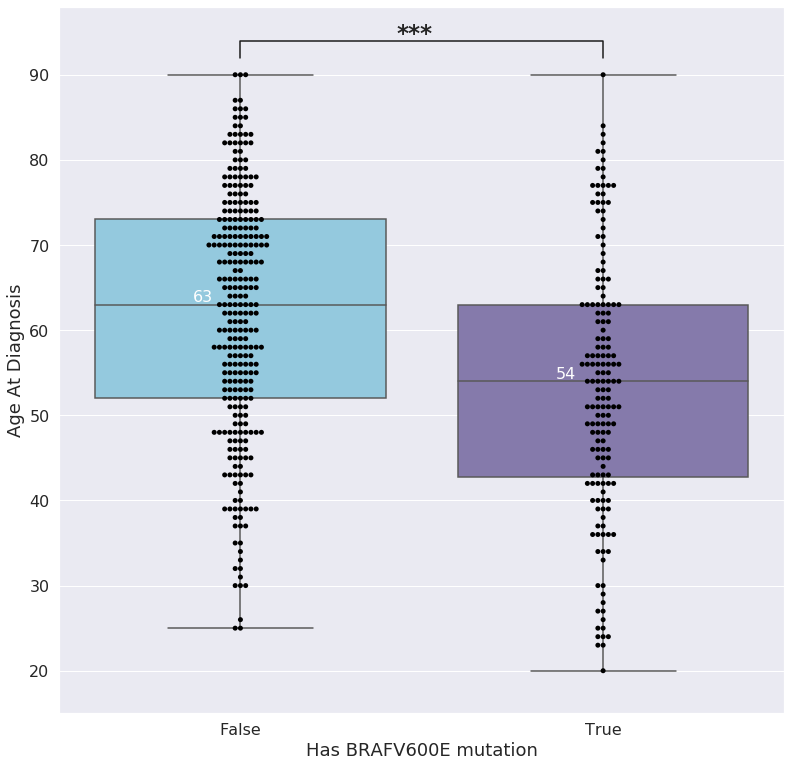

In [13]:
plt.figure(figsize=(13,13))

my_pal = {False: "skyblue", True:"m"}

sns.boxplot(data = tcgaSummary, x = "HasBRAFV600E", y = "Age", palette= my_pal)
sns.swarmplot(data = tcgaSummary, x = "HasBRAFV600E", y = "Age", color = "black")
plt.ylabel("Age At Diagnosis", fontsize = 18)
plt.xlabel("Has BRAFV600E mutation", fontsize = 18)

plt.text(-.13, 63.35, str(int(np.median(tcgaSummary[~tcgaSummary["HasBRAFV600E"]]["Age"]))), color = "white", fontsize = 16)
plt.text(0.87, 54.35, str(int(np.median(tcgaSummary[tcgaSummary["HasBRAFV600E"]]["Age"]))), color = "white", fontsize = 16)
plt.ylim(15, 100)

plt.plot([0,0,1,1], [92, 94, 94, 92], lw = 1.5, c = 'k')
plt.text(0.43, 94, "***", fontsize = 23, fontweight = "bold") #p-value above
plt.ylim(15,98)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

### 3d. Figure 3G and H - BRAFV600E, AI Allele Carrier Status, and Age of Diagnosis

**Figure 3G:**

Statistical analyses across individuals with/without BRAF V600E in those with and without AI MHC-I alleles

In [14]:
print("Is the BRAF-non BRAF age difference observed in AI allele carriers?")
stat,p = mannwhitneyu(tcgaSummary[(tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"], tcgaSummary[(tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"])
if p < 0.05:
    print("Yes: {}".format(p))
else:
    print("Nope: {}".format(p))
    
print("Is the BRAF-non BRAF age difference observed across non-AI allele carriers?")
stat,p = mannwhitneyu(tcgaSummary[(~tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"], tcgaSummary[(~tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"])
if p < 0.05:
    print("Yes: {}".format(p))
else:
    print("Nope: {}".format(p))

Is the BRAF-non BRAF age difference observed in AI allele carriers?
Yes: 8.118939955508858e-07
Is the BRAF-non BRAF age difference observed across non-AI allele carriers?
Yes: 0.000738860575554053


Generate figure:

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Text yticklabel objects>)

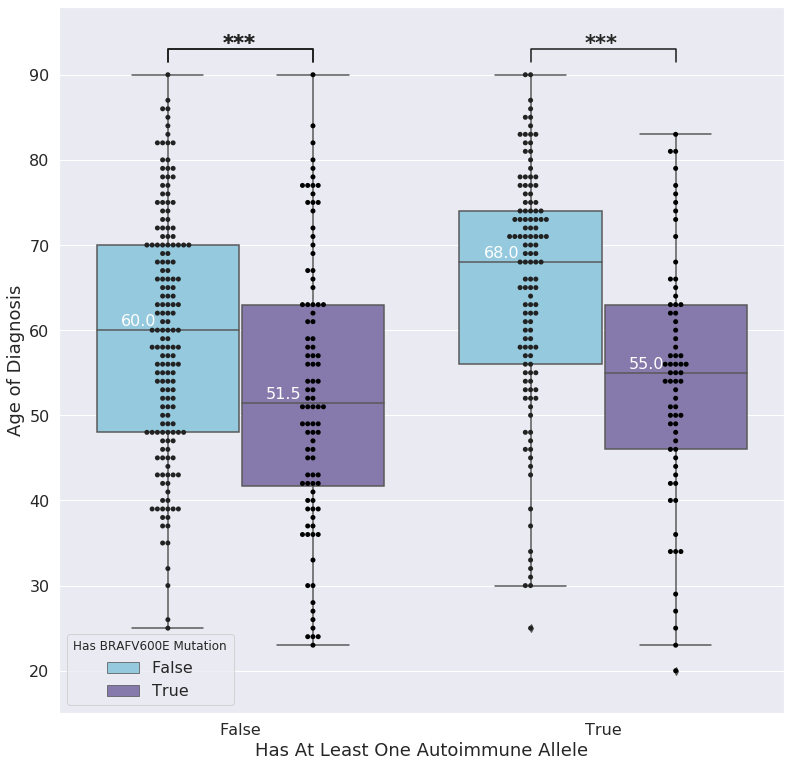

In [15]:
plt.figure(figsize=(13,13))

ax = sns.boxplot(data = tcgaSummary, x = "HasProtection", y="Age", hue = "HasBRAFV600E", palette=my_pal)
sns.swarmplot(data = tcgaSummary, x = "HasProtection", y="Age", hue = "HasBRAFV600E", color = "black", dodge = True)
plt.ylabel("Age of Diagnosis", fontsize = 18)
plt.xlabel("Has At Least One Autoimmune Allele", fontsize = 18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title = "Has BRAFV600E Mutation", loc = "lower left", frameon = True, fontsize  = 16)
plt.ylim(10, 99)

plt.plot([-0.2,-0.2,0.2,0.2], [91.5, 93, 93, 91.5], lw = 1.5, c = 'k')
plt.text(-0.05, 93, "***", fontsize = 21, fontweight = "bold") 
plt.plot([-0.2,-0.2,0.2,0.2], [91.5, 93, 93, 91.5], lw = 1.5, c = 'k')
plt.text(-0.05, 93, "***", fontsize = 21, fontweight = "bold") 
plt.plot([0.8,0.8,1.2,1.2], [91.5, 93, 93, 91.5], lw = 1.5, c = 'k')
plt.text(0.95, 93, "***", fontsize = 21, fontweight = "bold") 

plt.text(-0.33, 60.5, np.median(tcgaSummary[(~tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)
plt.text(0.07, 52, np.median(tcgaSummary[(~tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)

plt.text(0.67, 68.5, np.median(tcgaSummary[(tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)
plt.text(1.07, 55.5, np.median(tcgaSummary[(tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)
plt.ylim(15,98)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)



**Figure 3H:**

Statistical analyses across AI MHC-I allele carriers/non-carriers individuals and BRAF V600E mutation presence.

In [16]:
print("Is AI allele age difference observed across BRAF V600E mutation status?")
stat,p = mannwhitneyu(tcgaSummary[(tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"], tcgaSummary[(~tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"])
if p < 0.05:
    print("Yes: {}".format(p))
else:
    print("Nope: {}".format(p))
    
print("Is AI allele age difference observed across non-BRAF V600E mutation status?")
stat,p = mannwhitneyu(tcgaSummary[(tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"], tcgaSummary[(~tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"])
if p < 0.05:
    print("Yes: {}".format(p))
else:
    print("Nope: {}".format(p))

Is AI allele age difference observed across BRAF V600E mutation status?
Nope: 0.23231509306834386
Is AI allele age difference observed across non-BRAF V600E mutation status?
Yes: 0.00029766362206006


Generate figure:

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Text yticklabel objects>)

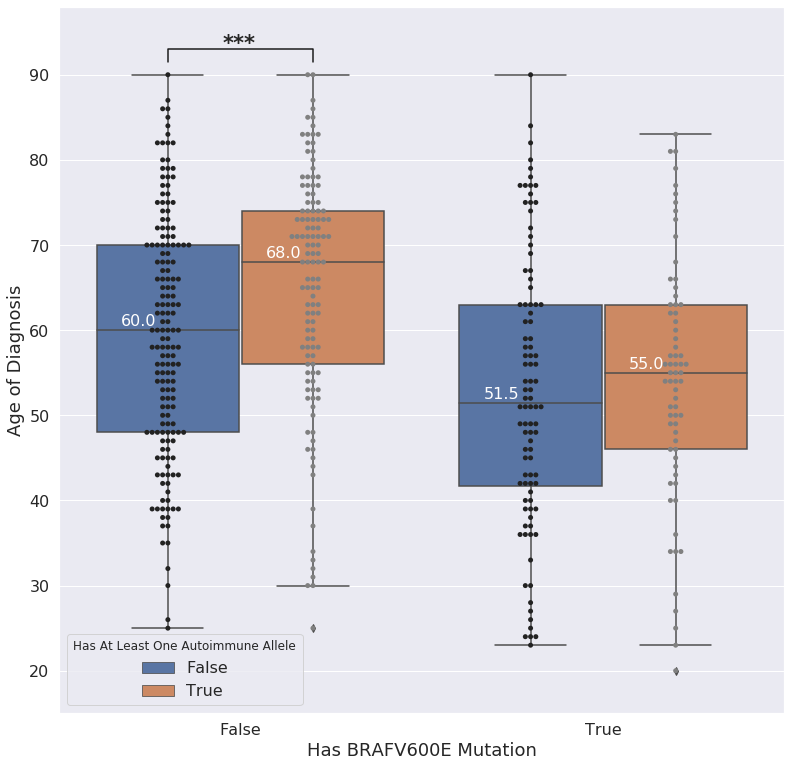

In [17]:
plt.figure(figsize=(13,13))
ax = sns.boxplot(data = tcgaSummary, hue = "HasProtection", y="Age", x = "HasBRAFV600E")
sns.swarmplot(data = tcgaSummary, hue = "HasProtection", y="Age", x = "HasBRAFV600E", color = "grey", dodge = True)
plt.ylabel("Age of Diagnosis", fontsize = 18)
plt.xlabel("Has BRAFV600E Mutation", fontsize = 18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title = "Has At Least One Autoimmune Allele", loc = "lower left", frameon = True, fontsize = 16)
plt.ylim(10, 99)

plt.plot([-0.2,-0.2,0.2,0.2], [91.5, 93, 93, 91.5], lw = 1.5, c = 'k')
plt.text(-0.05, 93, "***", fontsize = 21, fontweight = "bold") 
plt.text(-0.33, 60.5, np.median(tcgaSummary[(~tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)
plt.text(0.07, 68.5, np.median(tcgaSummary[(tcgaSummary["HasProtection"])&(~tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)

plt.text(0.67, 52, np.median(tcgaSummary[(~tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)
plt.text(1.07, 55.5, np.median(tcgaSummary[(tcgaSummary["HasProtection"])&(tcgaSummary["HasBRAFV600E"])]["Age"]), color = "white", fontsize = 16)
plt.ylim(15,98)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

### 3e. Figure 3I - Modeling Age of Diagnosis Including BRAF V600E Mutation Status

Formatting

In [18]:
#Encode Female status to be True (rather than letting smf randomly picking one and flipping the coefficient - done for consistency of results)
tcgaSummary["C_Sex"] = [int(el == "female") for el in tcgaSummary.Sex] 

Regression modeling

In [19]:
#Run model:
braiveTheDanger = smf.ols("Age ~ C(HasProtection)+C(HasBRAFV600E) + C_Sex + NumberMutations", data = tcgaSummary).fit()
summary = braiveTheDanger.summary()
resultsHTML = summary.tables[1].as_html()
summaryDF = pd.read_html(resultsHTML, header =0, index_col = 0)[0]
summaryDF["Labels"] = summaryDF.index
summaryDF["DoubleTrouble"] = 2*summaryDF["std err"]

#Format
summaryDF = summaryDF.drop(["Intercept"], axis = 0)
summaryDF.Labels = ["Has Autoimmune Allele", "Has BRAF V600E Mutation","Sex", "Mutation Burden"]
summaryDF


,coef,std err,t,P>|t|,[0.025,0.975],Labels,DoubleTrouble
C(HasProtection)[T.True],3.9652,1.392,2.849,0.005,1.230,6.700,Has Autoimmune Allele,2.784
C(HasBRAFV600E)[T.True],-7.9122,1.444,-5.480,0.000,-10.750,-5.075,Has BRAF V600E Mutation,2.888
C_Sex,1.9630,1.438,1.365,0.173,-0.863,4.789,Sex,2.876
NumberMutations,0.0028,0.001,2.456,0.014,0.001,0.005,Mutation Burden,0.002


In [20]:
#List all p-values from model
braiveTheDanger.pvalues

Intercept                   2.379943e-169
C(HasProtection)[T.True]     4.587413e-03
C(HasBRAFV600E)[T.True]      7.119319e-08
C_Sex                        1.729460e-01
NumberMutations              1.443545e-02
dtype: float64

Generate figure:

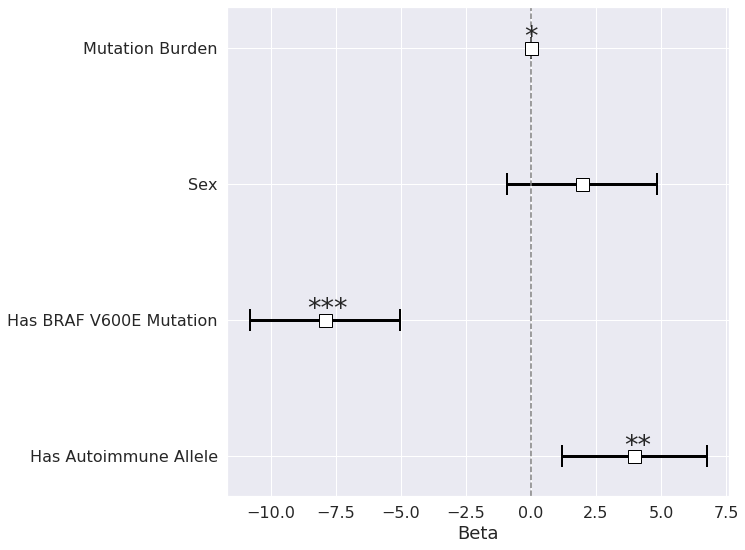

In [21]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.set(font_scale=1.1)
plt.errorbar(summaryDF.coef, summaryDF.Labels, xerr=summaryDF.DoubleTrouble, fmt='s', mfc = "white",color='black',
             ecolor='black', elinewidth=3, capsize = 11, markersize = 13, capthick = 2);

plt.ylim(-0.3,3.3)
plt.text(summaryDF.loc["C(HasProtection)[T.True]", "coef"] - 0.39, 0.01, "**", fontsize = 27)
plt.text(summaryDF.loc["C(HasBRAFV600E)[T.True]", "coef"] - 0.69, 1.02, "***", fontsize = 27)
plt.text(summaryDF.loc["NumberMutations", "coef"] - 0.25, 3.02, "*", fontsize = 27)
plt.xlabel("Beta", fontsize = 18) 
ax.tick_params(labelsize=16)
plt.axvline(0,linestyle="--",color="gray")